# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]

sqrt(mean_squared_error(y_true,y_pred))

5.746042116100439

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [290]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [292]:
# Проверим есть ли в признаке job пропущенные значения, возможно, они обозначены каким-то специальным словом
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [293]:
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

In [294]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
    
    
df['balance'] = df['balance'].apply(make_convert)

In [295]:
df['balance'].head()

0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64

In [296]:
print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [297]:
# обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [298]:
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [299]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
m_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)

In [300]:
m_educ = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_educ if x == 'unknown' else x)

In [301]:
print(df['education'].mode())
print(df['job'].mode())

0    secondary
Name: education, dtype: object
0    management
Name: job, dtype: object


In [302]:
print(round(df[(df.job == 'management') & (df.education=='secondary')]['balance'].mean(), 3))


1598.883


### Задание 6

In [303]:
# удалим все выбросы для признака balance
Q1 = np.percentile(df['balance'], 25)
Q3 = np.percentile(df['balance'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR



outliers = df[(df['balance'] < lower_bound) | (df['balance'] > upper_bound)] 
cleaned = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)] 




In [304]:
print(f'потенциальные выбросы {outliers.shape[0]}')
print(f'нижняя граница по методу Тьюки {lower_bound}')
print(f'верхняя граница по методу Тьюки {upper_bound}')
print(f'После очистки осталось {cleaned.shape[0]} записей.')


потенциальные выбросы 1057
нижняя граница по методу Тьюки -2241.0
верхняя граница по методу Тьюки 4063.0
После очистки осталось 10105 записей.


In [305]:
df_clean = cleaned.copy()

In [306]:
display(df_clean)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

### Задание 1

In [307]:
# изучим соотношение классов в наших данных на предмет несбалансированности
df_clean['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

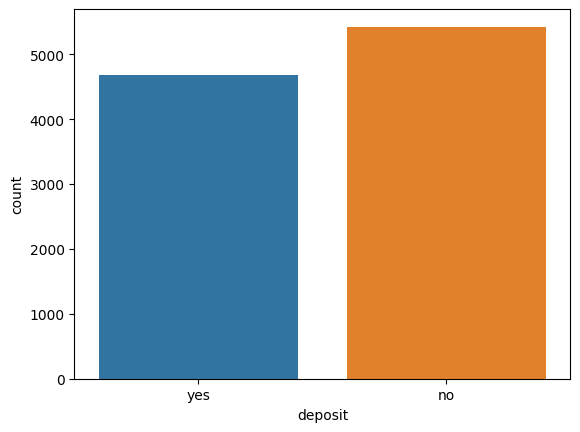

In [308]:
#Посмотрим на графике 
sns.countplot(x=df_clean['deposit']);

Исходя из данных можно сказать, что более чем 50% клиентов не являются вкладчиками. Далее будем выяснять какие факторы на это влияют.

### Задания 2 и 3

In [309]:
# рассчитаем описательные статистики для количественных переменных
df_clean.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Сделаю предварительный вывод по наиболее важным на мой взгляд показателям.

1. **Возраст**: как мы видим на обслуживание в банке принимаются клиенты от 18 лет, максимальный возраст составляет 95 лет, средний возраст в свою очередь составляет 40-41 год, исходя из данных по 25,50,75 квартилям можно сказать что основная клиентская база находится в диапазоне от 32 до 48 лет.
2. **Баланс**: минимальная сумма составляет -2049(задолженность клиента перед банком, вероятнее всего либо кредит, кредитная карта, овердрафт, пени начисленные банком). Максимальная же сумма баланса составляет 4063, средний баланс по клиентам составляет 807.65$, наибольшее количество клиентов имеют баланс от 95 до 1227$, 50% квартиль равна 445$ как видно разница со средним более чем на 350$, так же имеем большой показатель среднего отклонения, вероятнее всего это может быть связано с тем, что в банке имеется определенная категория(небольшое количество, либо и вовсе может быть выброс) очень состоятельных клиентов.
3. Посмотрим на показатели **duration**,**previous** и **campaign**. Как мы видим максимальное количество контактов по предыдущей кампании = 58, по текущей = 43, минимальные значения в свою очередь по предыдущей 0 по текущей 1. Среднее количество контактов по предыдущей 0.8 по текущей 2.5. Наибольшее количество контактов по предыдущей компании находится в диапазоне 0-1(50 квартиль = 0, т.е с большим количеством клиентов просто не контактировали) , по текущей 1-3( 50 квартиль = 2,т.е. в текущей кампании с большим количеством клиентов состоялось 2 контакта). Так же видим большую разницу в среднем отклонении по предыдущей компании, вероятно связано с тем, что опять таки может значить, что контактов с какой то определенной группой клиентов состоялось больше чем нужно. Что касаемо продолжительности контакта, то здесь можно увидеть максимальное значени 3881 секунд(1 час 4 минуты), минимальное 2 секунды(скорее всего просто сбросы после представления),больший диапазо (137-490 секунд(50 квартиль 252 секунды, т.е с большим количеством клиентов разговор длился примерно 4 минуты )), среднее же значение составляет 368 секунд.

Построим графики чтобы иметь большее понимание о данных:

In [310]:
#Посмотрим на возраст

import plotly.express as px
fig = px.scatter(x=df_clean['age'])
fig.update_layout(xaxis_title="Возраст клиента", yaxis_title="Количество клиентов")

fig.show()

Действительно, как мы видим,количество клиентов резко редеет после отметки в 60, так же  у нас имеется не так много клиентов возрастом 87+.

Так же имеет смысл посмотреть связь возраста клиента с его балансом. Выберем топ-10.

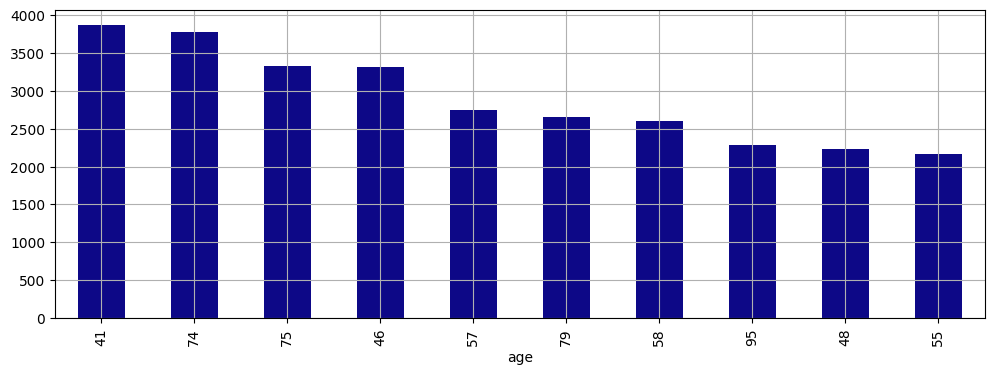

In [311]:
grouped_age_balance = df_clean.groupby(['age'])['balance'].last()
grouped_age_balance = grouped_age_balance.nlargest(10)
grouped_age_balance.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

Как мы видим, больший баланс находится на счетах у людей 40+ лет, топ-1 41 год, а вот 2 и 3 74 и 75 лет, т.е. возрастные люди вероятно имеют большую склонность держать средства на счёте, и возможно более заинтересованы в приобретении депозита.

### Задания 4 и 5

In [312]:
#рассчитаем описательные статистики для категориальных переменных
df_clean.describe(include='object')


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Исходя из полученных данных можем сказать, что большее количество клиентов работает в сфере менеджмента, женаты, имеют среднее образование, не имеют просрочек, не имеют кредитов,не имеют депозита.

In [313]:
df_clean['education'].value_counts()

secondary    5517
tertiary     3239
primary      1349
Name: education, dtype: int64

<AxesSubplot: xlabel='education', ylabel='count'>

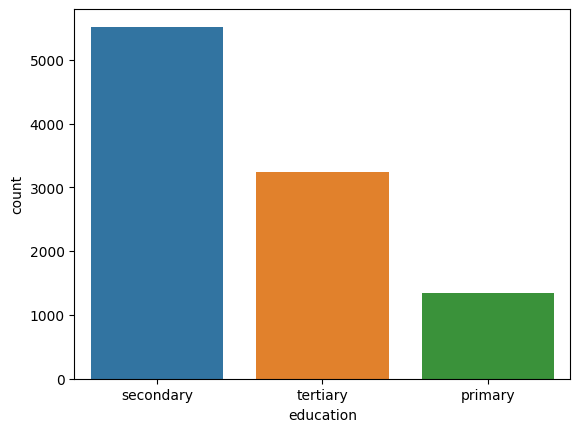

In [314]:
sns.countplot(x=df_clean['education'])

Как мы видим меньше всего людей с начальным образованием( в район 1500), далее идут люди с высшим образованием их около 3200 человек, и лидером является категория Среднее образования которых свыше 5000

<AxesSubplot: xlabel='count', ylabel='job'>

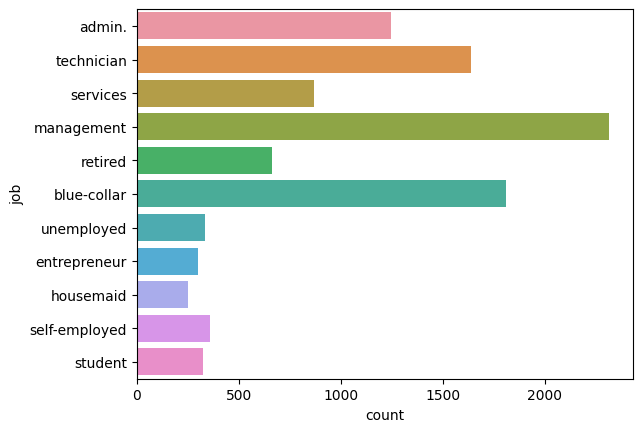

In [315]:
sns.countplot(y=df_clean['job'])

Топ 3 категории являются категориия относящиеся к сфере менеджмента, "синим воротничкам", и технической отрасли.

### Задание 6

<AxesSubplot: xlabel='poutcome'>

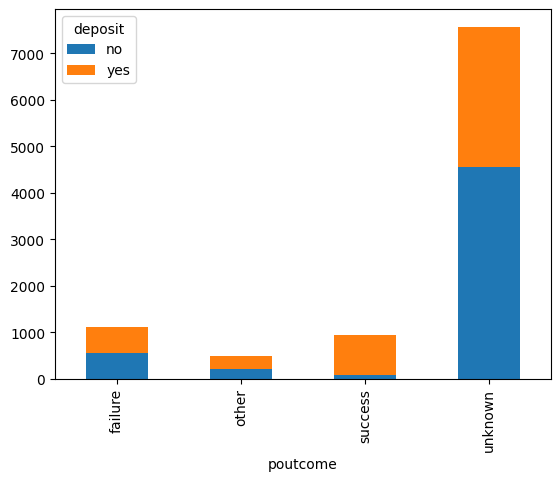

In [316]:
# Посмотрим, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
result = df_clean.groupby('poutcome')['deposit'].value_counts(normalize = False).unstack()
result.plot(kind='bar',stacked=True)

Как мы видим, клиенты которые согласились на депозит при прошлой кампании более склонны согласиться и в текущей.

### Задание 7

In [317]:
# Посмотрим, в каком месяце чаще всего отказывались от предложения открыть депозит
res_no = df_clean[df_clean.deposit == 'no'].groupby(['month'])['deposit'].count()
res_all = df_clean.groupby(['month'])['deposit'].count()

res_no/res_all

month
apr    0.381928
aug    0.559567
dec    0.096774
feb    0.455571
jan    0.608150
jul    0.589563
jun    0.548913
mar    0.101266
may    0.678640
nov    0.584615
oct    0.185075
sep    0.165468
Name: deposit, dtype: float64

Как видим, наибольшее количество отказов мы получаем в мае месяце.

### Задание 8

In [318]:
# Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_diap(age):
    if age < 30:
        return '<30'
    elif age >=30 and age < 40:
        return '30-40'
    elif age >=40 and age < 50:
        return '40-50'
    elif age >= 50 and age < 60:
        return '50-60'
    elif age >= 60:
        return '60+'
    
    
        

In [319]:
df_clean['age_diapason'] = df_clean['age'].apply(age_diap)

<AxesSubplot: xlabel='age_diapason', ylabel='count'>

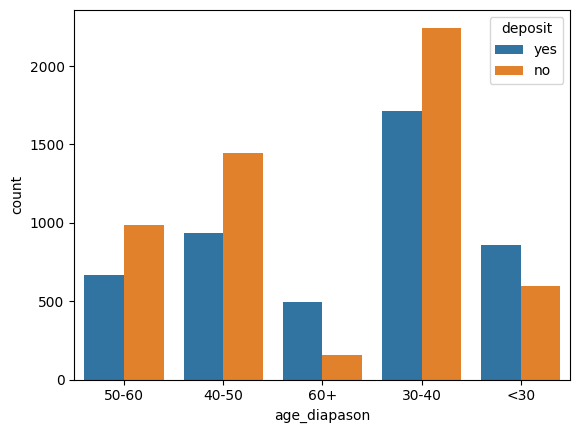

In [320]:
sns.countplot(x = 'age_diapason', hue = 'deposit', data =df_clean)

Исходя из визуализации, мы видим, что более склонны соглашаться на открытие депозита, чем отказываться 2 возрастные группа, это возрастная группа <30 лет и более 60. Выведем значения в числах.

In [321]:
print('Доля согласий в возрастной группе до 30 лет:', (df_clean[(df_clean['deposit'] == 'yes') & (df_clean['age_diapason'] == '<30')].count()/df_clean[(df_clean['age_diapason'] == '<30')].count())['deposit']*100 )
print('Доля согласий в возрастной группе от 30 до 40 лет:', (df_clean[(df_clean['deposit'] == 'yes') & (df_clean['age_diapason'] == '30-40')].count()/df_clean[(df_clean['age_diapason'] == '30-40')].count())['deposit']*100 )
print('Доля согласий в возрастной группе от 40 до 50 лет:', (df_clean[(df_clean['deposit'] == 'yes') & (df_clean['age_diapason'] == '40-50')].count()/df_clean[(df_clean['age_diapason'] == '40-50')].count())['deposit']*100 )
print('Доля согласий в возрастной группе от 50 до 60 лет:', (df_clean[(df_clean['deposit'] == 'yes') & (df_clean['age_diapason'] == '50-60')].count()/df_clean[(df_clean['age_diapason'] == '50-60')].count())['deposit']*100 )
print('Доля согласий в возрастной группе старше 60 лет:', (df_clean[(df_clean['deposit'] == 'yes') & (df_clean['age_diapason'] == '60+')].count()/df_clean[(df_clean['age_diapason'] == '60+')].count())['deposit']*100 )

Доля согласий в возрастной группе до 30 лет: 59.175257731958766
Доля согласий в возрастной группе от 30 до 40 лет: 43.322393335016415
Доля согласий в возрастной группе от 40 до 50 лет: 39.37867338371117
Доля согласий в возрастной группе от 50 до 60 лет: 40.507859733978236
Доля согласий в возрастной группе старше 60 лет: 75.95712098009189


### Задания 9 и 10

<AxesSubplot: xlabel='marital', ylabel='count'>

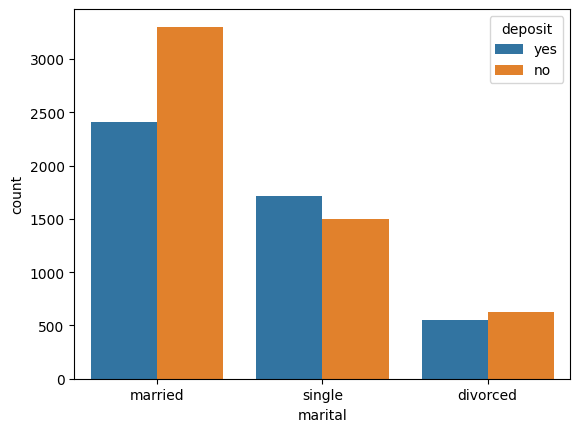

In [322]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(x = 'marital', hue = 'deposit', data =df_clean)

Видим что большее количество клиентов состоит в браке, но более заинтересованы в открытии депозита люди не состоящие в браке(не относится к находящимся в разводе)

<AxesSubplot: xlabel='deposit', ylabel='count'>

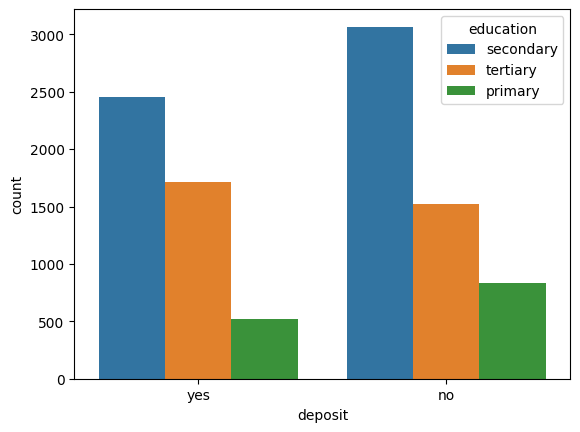

In [323]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(x = 'deposit', hue = 'education', data =df_clean)

Как видно из данной диаграммы, большее количество вкладчиков имеют среднее образование, но по соотношению согласиться либо отказаться от вклада, в плане согласия лидируют люди с высшим образованием 

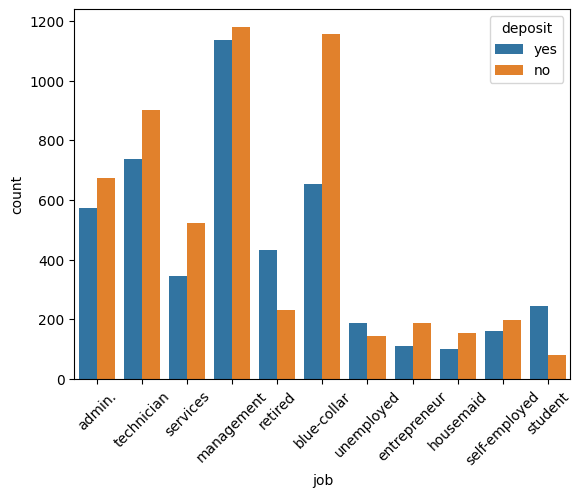

In [324]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(x = 'job', hue = 'deposit', data =df_clean)
plt.xticks(rotation = 45);

Наибольшее количество клиентов банка трудоустроены в сфере менеджмента, но по соотношению согласиться отказаться от депозита, наиболее часто принимают решение о согласии клиенты пенсионеры, а так же студенты.

### Задание 11

In [325]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pd.crosstab(df_clean['deposit']=='yes', [df_clean['education'], df_clean['marital']])

education  primary                secondary                tertiary          \
marital   divorced married single  divorced married single divorced married   
deposit                                                                       
False           91     641    100       370    1830    866      163     832   
True            96     339     82       283    1289    879      174     784   

education         
marital   single  
deposit           
False        531  
True         755

Как видим, люди имеющие среднее образование, при этом состоящие в браке, самая многочисленная группа из всех прочих.

## Часть 3: преобразование данных

### Задание 1

In [326]:
# преобразуем уровни образования
#Создаём экземпляр класса LabelEncoder
lab_enc = LabelEncoder()

#Кодируем признак
df_clean['education'] = lab_enc.fit_transform(df_clean['education'])


In [327]:
df_clean['education'].sum()

11995

In [328]:
#Так же закодируем созданную ранее порядковую переменную с возрастным диапазоном
df_clean['age_diapason'] = lab_enc.fit_transform(df_clean['age_diapason'])

In [329]:
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_diapason
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


In [330]:
df_clean['contact'].value_counts()

cellular     7283
unknown      2161
telephone     661
Name: contact, dtype: int64

### Задания 2 и 3

In [331]:
# преобразуем бинарные переменные в представление из нулей и единиц
#Закодируем  бинарные признаки
lab_bin = preprocessing.LabelBinarizer()
df_clean['default'] =lab_bin.fit_transform(df_clean['default'])
df_clean['housing'] = lab_bin.fit_transform(df_clean['housing'])
df_clean['loan'] = lab_bin.fit_transform(df_clean['loan'])
df_clean['deposit'] = lab_bin.fit_transform(df_clean['deposit'])

In [332]:
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_diapason
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [333]:
print(round(df_clean['deposit'].std(),3))

0.499


In [334]:
print(round(df_clean['housing'].mean() + df_clean['loan'].mean() + df_clean['default'].mean(),3))

0.635


### Задание 4

In [335]:
# создадим дамми-переменные
df_clean = pd.get_dummies(df_clean,columns = ['job','month','marital','contact','poutcome'])
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int32  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int32  
 5   loan               10105 non-null  int32  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int32  
 12  age_diapason       10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

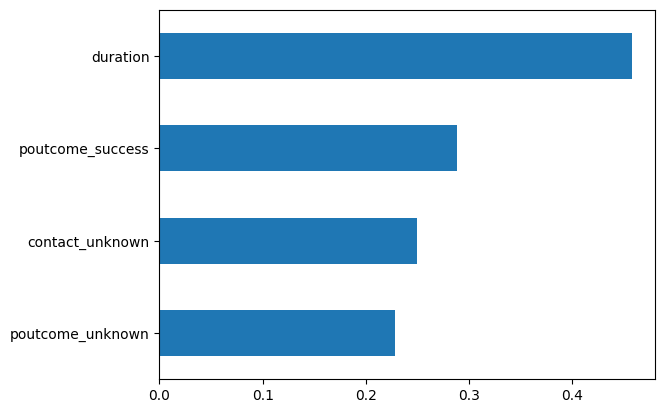

In [336]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
corr = df_clean.corr()
corr['deposit'].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.show()

<AxesSubplot: >

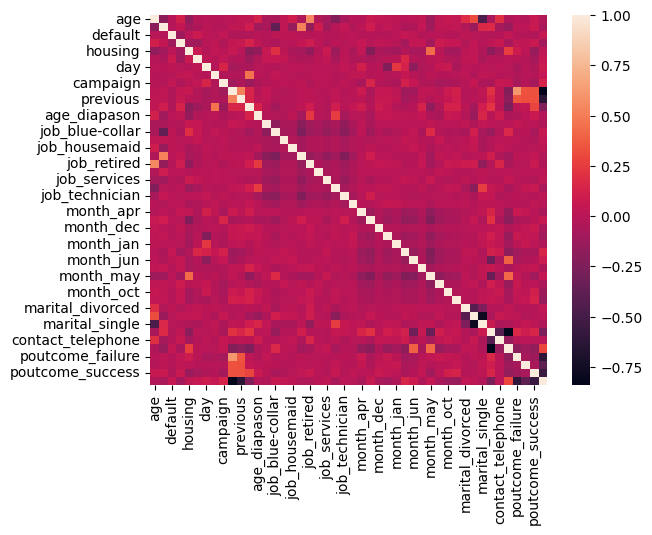

In [337]:
#Посмотрим на тепловую карту
sns.heatmap(df_clean.corr())

### Задания 7 и 8

In [338]:
X = df_clean.drop(['deposit'], axis=1)
y = df_clean['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [339]:
# рассчитаем необходимые показатели
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3335 entries, 3333 to 3818
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3335 non-null   int64  
 1   education          3335 non-null   int32  
 2   default            3335 non-null   int32  
 3   balance            3335 non-null   float64
 4   housing            3335 non-null   int32  
 5   loan               3335 non-null   int32  
 6   day                3335 non-null   int64  
 7   duration           3335 non-null   int64  
 8   campaign           3335 non-null   int64  
 9   pdays              3335 non-null   int64  
 10  previous           3335 non-null   int64  
 11  age_diapason       3335 non-null   int32  
 12  job_admin.         3335 non-null   uint8  
 13  job_blue-collar    3335 non-null   uint8  
 14  job_entrepreneur   3335 non-null   uint8  
 15  job_housemaid      3335 non-null   uint8  
 16  job_management     33

In [340]:
print(round(y_test.mean(),2))

0.46


### Задание 9

In [341]:
# с помощью SelectKBest отберём 15 наиболее подходящих признаков
selector = SelectKBest(f_classif,k=15)
selector.fit(X_train,y_train)

selector.get_feature_names_out()


array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_diapason', 'month_mar', 'month_may', 'month_oct', 'month_sep',
       'contact_cellular', 'contact_unknown', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [342]:
df = df_clean[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_diapason', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           10105 non-null  float64
 1   housing           10105 non-null  int32  
 2   duration          10105 non-null  int64  
 3   campaign          10105 non-null  int64  
 4   pdays             10105 non-null  int64  
 5   previous          10105 non-null  int64  
 6   age_diapason      10105 non-null  int32  
 7   contact_cellular  10105 non-null  uint8  
 8   contact_unknown   10105 non-null  uint8  
 9   month_mar         10105 non-null  uint8  
 10  month_may         10105 non-null  uint8  
 11  month_oct         10105 non-null  uint8  
 12  month_sep         10105 non-null  uint8  
 13  poutcome_success  10105 non-null  uint8  
 14  poutcome_unknown  10105 non-null  uint8  
 15  deposit           10105 non-null  int32  
dtypes: float64(1), int32(3), int64(4), uint8

In [343]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [344]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [345]:
print(round(X_test_scaled[:,0].mean(),2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [346]:
# обучим логистическую регрессию и рассчитаем метрики качества
log_reg = linear_model.LogisticRegression(
    solver = 'sag',
    random_state = 42,
    max_iter = 1000
)

log_reg.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [347]:
#Делаем предсказание для тренировочного набора данных
y_pred_train = log_reg.predict(X_train_scaled)
print(metrics.classification_report(y_train,y_pred_train))

#Делаем предсказание для тестовой выборки 
y_pred_test = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Как видим метрика accuracy на тренировочной выборке составляет 0.82, а на тестовой 0.80, т.е. модель обучилась достаточно хорошо,расхождения минимальны, и мы не наблюдаем ни недообучения ни переобучения соответственно.

### Задания 2,3,4

In [348]:
# обучим решающие деревья
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt.fit(X_train_scaled,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [349]:
#Делаем предсказание для тренировочного набора данных
y_pred_train = dt.predict(X_train_scaled)
print(metrics.classification_report(y_train,y_pred_train))

#Делаем предсказание для тестовой выборки 
y_pred_test = dt.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Как мы видим, на тренировочной модели все метрики = 1, на тестовой в свою очередь метрика accuracy = 0.75, т.е. здесь очевидное переобучение модели, попробуем скорректировать модель путем добавления параметров, а конкретно добавим параметр отвечающий за глубину дерева.

In [350]:
# обучим решающие деревья
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth= 6
)

dt.fit(X_train_scaled,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [351]:
#Делаем предсказание для тренировочного набора данных
y_pred_train = dt.predict(X_train_scaled)
print(metrics.classification_report(y_train,y_pred_train))

#Делаем предсказание для тестовой выборки 
y_pred_test = dt.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



Путём перебора значений удалось выяснить, что оптимальный параметр глубины дерева = 6, т.к. с 7 уже начинается небольшое переобучение модели, остановимся на 6.

### Задание 5

In [352]:
# подберём оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters = {'min_samples_split': [2,5,7,10], 'max_depth': [3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(),
                        parameters,
                        cv=3,
                        scoring=('f1'),
                        return_train_score=True)

model_cv.fit(X_train_scaled,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]},
             return_train_score=True, scoring='f1')

In [353]:
#Посмотрим наилучшую комбинацию гиперпараметров:
print('Наилучшее значение параметров:{}'.format(model_cv.best_params_))
#Для общей информации сверим accuracy
print('accuracy на тестовом наборе: {:.2f}'.format(model_cv.score(X_test_scaled, y_test)))
#Т.к. основная метрика на которую ориентируемся f1 смотрим его
y_test_pred = model_cv.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшее значение параметров:{'max_depth': 7, 'min_samples_split': 2}
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [354]:
# обучите на наших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf= 5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [355]:
y_test_pred = rf.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(rf.score(X_test_scaled, y_test)))
print('recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.83
recall на тестовом наборе: 0.83
f1 на тестовом наборе: 0.82


### Задания 2 и 3

In [356]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

#Обучаем модель
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [357]:
gb_test_pred = gb.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(gb.score(X_test_scaled, y_test)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, gb_test_pred)))
print('recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, gb_test_pred)))

accuracy на тестовом наборе: 0.83
f1 на тестовом наборе: 0.82
recall на тестовом наборе: 0.83


Как видим метрики по результатам 2 разных моделей абсолютно идентичны, отсюда можно сделать вывод что они обе обладают одинаковой эффективностью.

### Задание 4

In [358]:
# объединитм уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('log_reg', linear_model.LogisticRegression(
    solver = 'sag',
    random_state = 42,
    max_iter = 1000)),
    
    ('dt', tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth= 6)),
    
    ('gb', GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42))
    ]

In [359]:
#Создаём ансамбль
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

#Обучаем
stack.fit(X_train_scaled,y_train)

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [360]:
#Формируем предсказание для тестовой выборки
y_pred_stack = stack.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_pred_stack)))

precision на тестовом наборе: 0.80


### Задание 5

In [373]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE
rfe = RFE(gb,n_features_to_select=3,step=1)

rfe.fit(X_test_scaled,y_test)

rfe.get_feature_names_out()

array(['x0', 'x2', 'x13'], dtype=object)

Как видим наиболее важными признаками у нас являются duration,poutcome_success,contact_unknown.

### Задания 6,7,8

In [362]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [364]:
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier",direction="maximize")

# ищем лучшую комбинацию гиперпараметров 20 раз.
study.optimize(optuna_rf, n_trials=20)

[I 2023-08-21 13:51:24,531] A new study created in memory with name: RandomForestClassifier
[I 2023-08-21 13:51:25,053] Trial 0 finished with value: 0.8560250391236306 and parameters: {'n_estimators': 114, 'max_depth': 23, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8560250391236306.
[I 2023-08-21 13:51:25,923] Trial 1 finished with value: 0.8520950594121326 and parameters: {'n_estimators': 199, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8560250391236306.
[I 2023-08-21 13:51:26,519] Trial 2 finished with value: 0.8450172901603269 and parameters: {'n_estimators': 144, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8560250391236306.
[I 2023-08-21 13:51:26,990] Trial 3 finished with value: 0.8484848484848485 and parameters: {'n_estimators': 105, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8560250391236306.
[I 2023-08-21 13:51:27,516] Trial 4 finished with value: 0.8618421052631579 and parameters: {'n

In [365]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 184, 'max_depth': 30, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.90


In [366]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81


Исходя из всех проведенных выше действий мы можем сказать, что наиболее эффективными модели являются модели Градиентного бустинга и модель логистической регрессии, стекинг и optuna со своей задачей в данном виде не справились, вероятно необходимо уделить больше времене в optuna для того, чтобы она провела большее количество итераций и выдала более качественные гиперпараметры.